# Data Transformation and Preparation

In [109]:
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# read the data
spotify = pd.read_csv('data/Hot 100 Audio Features.csv')
billboard = pd.read_csv('data/Hot Stuff.csv')

# join on song id
spotify = spotify.drop_duplicates(subset=['SongID']) # drop duplicates in spotify
df = pd.merge(spotify, billboard, on=['SongID'], how='right', validate='one_to_many')
df.drop(columns=['index_y', 'index_x', 'Performer_y', 'Song_y'], inplace = True) # get rid of index and duplicate columns

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327895 entries, 0 to 327894
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   SongID                     327895 non-null  object 
 1   Performer_x                327817 non-null  object 
 2   Song_x                     327817 non-null  object 
 3   spotify_genre              313371 non-null  object 
 4   spotify_track_id           284728 non-null  object 
 5   spotify_track_preview_url  168700 non-null  object 
 6   spotify_track_duration_ms  284728 non-null  float64
 7   spotify_track_explicit     284728 non-null  object 
 8   spotify_track_album        284666 non-null  object 
 9   danceability               284170 non-null  float64
 10  energy                     284170 non-null  float64
 11  key                        284170 non-null  float64
 12  loudness                   284170 non-null  float64
 13  mode                       28

In [110]:
# get numeric columns
num_cols = df.select_dtypes(include='number').columns.to_list()

# transform the data so that each row corresponds to a genre-year combination
# aggregate the numeric columns over that combination
df['Year'] = df['WeekID'].apply(lambda x: x.split('/')[2]) # create year column from weekid
df = df.dropna(subset=['spotify_genre']) # drop rows with no genre
df['spotify_genre'] = df['spotify_genre'].apply(ast.literal_eval) # make genre field a list not string
df = df.explode('spotify_genre') # genre is a list of genres for each song, want one genre for each song
genre_df = df.groupby(['spotify_genre', 'Year']).agg({col: 'mean' for col in num_cols}).reset_index()
song_counts = df.groupby(['spotify_genre', 'Year']).size().reset_index(name='song_count') # get song counts
genre_df = pd.merge(genre_df, song_counts, on=['spotify_genre', 'Year'], how='left') # merge song counts with genre_df

# add lag features for each numeric column
for col in num_cols:
    genre_df[f'{col}_lag1'] = genre_df.groupby('spotify_genre')[col].shift(1) # 1 year lag feature for each numeric column
    genre_df[f'{col}_lag2'] = genre_df.groupby('spotify_genre')[col].shift(2) # 2 year lag feature for each numeric column
    
# add lag features for song count
genre_df['song_count_lag1'] = genre_df.groupby('spotify_genre')['song_count'].shift(1) # 1 year lag feature for song count
genre_df['song_count_lag2'] = genre_df.groupby('spotify_genre')['song_count'].shift(2) # 2 year lag feature for song count
    
# now add my target variable, song count 2 years later
genre_df['song_count_2yr'] = genre_df.groupby('spotify_genre')['song_count'].shift(-2) # song count 2 years later

print(genre_df.head())
print(genre_df.info())

            spotify_genre  Year  spotify_track_duration_ms  danceability  \
0  21st century classical  1969                        NaN           NaN   
1              a cappella  1960                        NaN           NaN   
2              a cappella  1962              176153.777778      0.447222   
3              a cappella  1963              174740.423729      0.516186   
4              a cappella  1964              181078.444444      0.607444   

     energy       key   loudness      mode  speechiness  acousticness  ...  \
0       NaN       NaN        NaN       NaN          NaN           NaN  ...   
1       NaN       NaN        NaN       NaN          NaN           NaN  ...   
2  0.175333  4.333333 -18.251556  0.111111     0.049922      0.848778  ...   
3  0.218542  6.067797 -18.188373  1.000000     0.038598      0.717441  ...   
4  0.252333  3.333333 -11.744889  1.000000     0.034522      0.776333  ...   

   Instance_lag2  Previous Week Position_lag1  Previous Week Position_lag2

# Exploratory Data Analysis

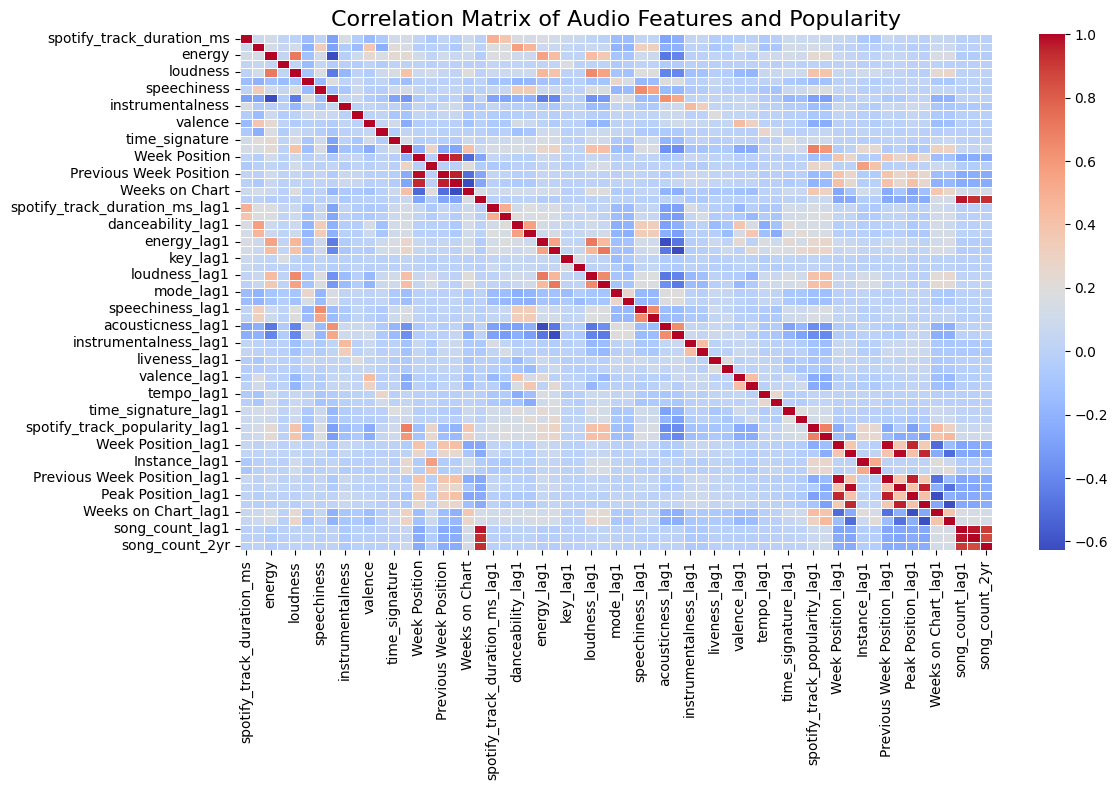

In [111]:
# plot correlation matrix heatmap
corr = genre_df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Correlation Matrix of Audio Features and Popularity", fontsize=16)
plt.tight_layout()
plt.show()

<Axes: >

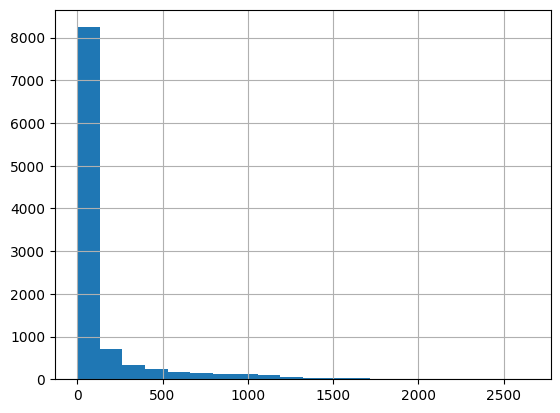

In [112]:
# explore target variable distribution
genre_df['song_count_2yr'].hist(bins=20)

After looking at the distribution of my target variable, it's clearly very skewed. Most models trained with this raw target variable will simply learn to predict a lower song count. To try and fix this, I'll perform a log transformation which till make the distribution more normal. The model will learn with the log-transformed values instead and when I get the prediction I can inverse the transformation to get raw song counts again.

<Axes: >

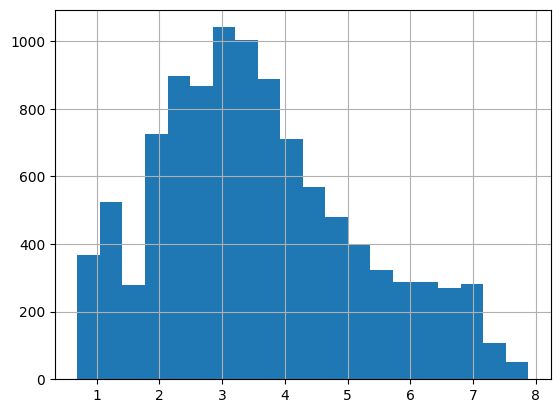

In [113]:
# log transform the target variable to make distribution more normal
genre_df['song_count_2yr'] = np.log1p(genre_df['song_count_2yr'])
genre_df['song_count_2yr'].hist(bins=20)

In [117]:
# handle missing values (decide which ones to impute and leave ones I want to drop as na)
# lag features with na will be dropped before training
# missing values for target variable will be held out for evaluation/forecasting
for col in num_cols:
    percent_na = (genre_df[col].isna().sum() / len(genre_df)) * 100
    print(f"{col} missing values: {percent_na:.2f}%, {col} skewness: {genre_df[col].skew():.2f}")
    

spotify_track_duration_ms missing values: 7.07%, spotify_track_duration_ms skewness: 4.43
danceability missing values: 7.11%, danceability skewness: -0.09
energy missing values: 7.11%, energy skewness: -0.39
key missing values: 7.11%, key skewness: -0.01
loudness missing values: 7.11%, loudness skewness: -0.65
mode missing values: 7.11%, mode skewness: -0.96
speechiness missing values: 7.11%, speechiness skewness: 3.57
acousticness missing values: 7.11%, acousticness skewness: 1.01
instrumentalness missing values: 7.11%, instrumentalness skewness: 4.41
liveness missing values: 7.11%, liveness skewness: 2.39
valence missing values: 7.11%, valence skewness: -0.36
tempo missing values: 7.11%, tempo skewness: 0.63
time_signature missing values: 7.11%, time_signature skewness: -5.47
spotify_track_popularity missing values: 7.07%, spotify_track_popularity skewness: -0.20
Week Position missing values: 0.00%, Week Position skewness: 0.20
Instance missing values: 0.00%, Instance skewness: 6.44
